# Deeplearning 8 team : Personalized Clothing Recommendation
---

### 주제

- **패션 시장의 변화와 새로운 추천 시스템의 필요성**

- **기존 추천 시스템의 한계**

- 기존 추천 시스템은 주로 장바구니 분석(연관 규칙 마이닝)과 같은 방법을 사용하여 고객이 이미 구매했거나 선택한 제품과 유사한 제품만을 추천

- **새로운 접근 방식: 고객 맞춤형 추천 시스템**

- 고객이 선택한 의류와 잘 어울리는 품목을 제안하는 새로운 추천 시스템을 개발했습니다.



- 고객의 쇼핑 경험을 더욱 풍부하게 만들고자 합니다.


## 파이프라인
<img src = "https://drive.google.com/uc?id=1SwyzRkUR7aHgsmps24BxQTs6lmqEagwz" height = 600 width = 1200>

### Data Intro : AI-HUB K-Fashion 이미지
---
https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=51



본 데이터는 패션 상품을 카테고리와 색상 속성으로 분류한 정보를 포함하고 있습니다. 주로 상의 카테고리와 색상 정보가 사용했습니다.

#### 1. 카테고리 속성

카테고리는 패션 상품을 분류하는 상위 체계의 속성입니다.  고객이 선택한 패션 아이템을 세분화하고, 보다 구체적인 추천을 제공하기 위해 다음과 같은 상의 카테고리를 5개를 사용했습니다:
- ["탑", "블라우스", "니트웨어", "셔츠", "티셔츠"]

#### 2. 색상 속성

색상 속성은 상품의 색상 정보를 고객의 사용도가 높은 색상으로 제공하여, 보다 직관적이고 사용자 친화적인 검색 및 추천 기능을 지원합니다. 주요 색상 속성은 다음과 같습니다:

- [블랙, 화이트, 그레이, 레드, 핑크, 오렌지, 베이지, 브라운, 옐로우, 그린, 카키, 민트, 블루, 네이비, 스카이블루, 퍼플, 라벤더, 와인, 네온, 골드]


### Data preprocessing

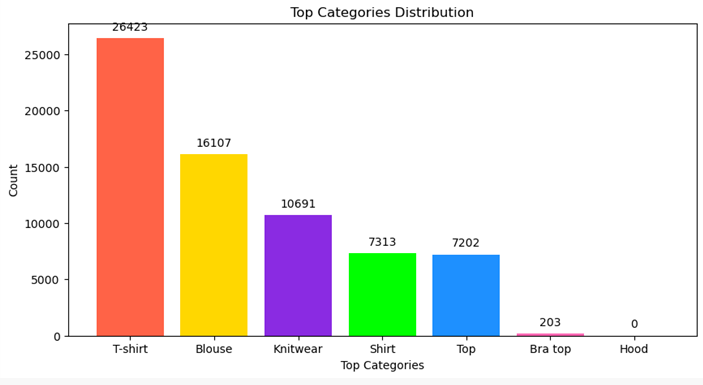

1. **JSON 파일 복사**:
   - 원천 데이터 폴더에서 JSON 파일을 복사하여 라벨 폴더에 저장.

2. **JSON 파일 필터링**:
   - '원피스' 또는 '아우터' 카테고리를 포함하는 항목을 제외한 JSON 파일 필터링.
   - 상의 항목만 포함하는 JSON 파일만 추출하여 저장.

3. **카테고리 분포 확인**:
   - 상의 카테고리('탑', '블라우스', '니트웨어', '셔츠', '티셔츠')의 분포 개수를 확인.

4. **카테고리별 JSON 파일 추출**:
   - 각 상의 카테고리별로 20,000개의 JSON 파일을 추출하여 별도 폴더에 저장.

5. **이미지 복사**:
   - 원본 이미지 폴더에서 JSON 파일과 이름이 같은 이미지를 추출하여 별도 폴더에 저장.

6. **이미지 리사이즈**:
   - 다양한 크기의 이미지를 256x256 크기로 리사이즈하여 저장.

7. **폴리곤 좌표 변환**:
   - 원본 이미지의 폴리곤 좌표 값을 256x256 크기에 맞게 변환하여 JSON 파일 저장.

8. **이미지 크롭 및 배경 추가**:
   - 폴리곤 좌표를 사용하여 이미지를 크롭하고, 크롭된 이미지를 검은 배경에 붙여 256x256 크기의 새로운 이미지 생성 및 저장.

## Image Segmentation


#### 데이터 로드 및 전처리

1. **JSON 파일 로드**:
   - 주어진 디렉토리에서 JSON 파일을 모두 로드하여 리스트로 저장

2. **create_mask_from_polygon()**:
   - 이미지에 폴리곤 좌표를 이용해 마스크를 생성

3. **preprocess_data()**:
   - 이미지를 로드하고, 폴리곤 데이터를 기반으로 마스크를 생성하여 전처리된 이미지와 마스크 배열을 반환

#### U-Net 모델 정의

1. **U-Net 모델 생성**:
   - 인코더와 디코더 블록을 포함하는 U-Net 모델을 정의하여 이미지 분할 작업에 사용
   - 인코더는 이미지를 다운샘플링하고, 디코더는 업샘플링하여 원본 이미지 크기로 복원
   - 스킵 연결을 사용하여 인코더의 특징 맵을 디코더에 전달

### 요약

- JSON 파일을 로드하고, 이미지와 폴리곤 데이터를 사용하여 마스크를 생성 및 전처리
- U-Net 모델을 정의하여 이미지 분할 작업을 수행 인코더와 디코더 블록, 스킵 연결을 사용하여 높은 정확도를 제공


In [ ]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# 데이터 로드 및 전처리 함수
def load_json_files(json_dir):
    json_files = [os.path.join(json_dir, f) for f in os.listdir(json_dir) if f.endswith('.json')]
    data = []
    for json_file in json_files:
        with open(json_file, 'r', encoding='utf-8') as file:
            data.append(json.load(file))
    return data

def create_mask_from_polygon(polygon, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    points = np.array(polygon, dtype=np.int32)
    cv2.fillPoly(mask, [points], 1)
    return mask

def preprocess_data(data, img_dir, target_size=(256, 256)):
    images = []
    masks = []
    for item in data:
        img_info = item['이미지 정보']
        img_name = '%d.jpg' % img_info['이미지 식별자']
        img_path = os.path.join(img_dir, img_name)

        if not os.path.exists(img_path):
            print(f"Image path does not exist: {img_path}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        img_height, img_width = img.shape[:2]

        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        # 상의 폴리곤 좌표
        for polygon in item['데이터셋 정보']['데이터셋 상세설명']['폴리곤좌표']['상의']:
            if polygon:
                coords = [(polygon[f'X좌표{i}'], polygon[f'Y좌표{i}']) for i in range(1, len(polygon) // 2 + 1)]
                mask += create_mask_from_polygon(coords, (img_height, img_width))

        # 하의 폴리곤 좌표
        for polygon in item['데이터셋 정보']['데이터셋 상세설명']['폴리곤좌표']['하의']:
            if polygon:
                coords = [(polygon[f'X좌표{i}'], polygon[f'Y좌표{i}']) for i in range(1, len(polygon) // 2 + 1)]
                mask += create_mask_from_polygon(coords, (img_height, img_width)) * 2

        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
        mask[mask > 2] = 2
        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# UNet 모델 정의
def unet_model(input_size=(256, 256, 3), num_classes=3):
    inputs = layers.Input(input_size)

    # 인코더
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # 중심
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # 디코더
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# 설정 및 모델 인스턴스 생성
input_size = (256, 256, 3)
num_classes = 3  # 배경 + 상의 + 하의


In [ ]:
json_dir = './data/topbottom_label'
img_dir = './data/resized_images'
data = load_json_files(json_dir)
images, masks = preprocess_data(data, img_dir)
# 모델 학습

In [ ]:
model = unet_model(input_size=input_size, num_classes=num_classes)

# 모델 컴파일
model.compile(optimizer=optimizers.Adam(learning_rate=3e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_28[0][0]']              
                                )                                                           

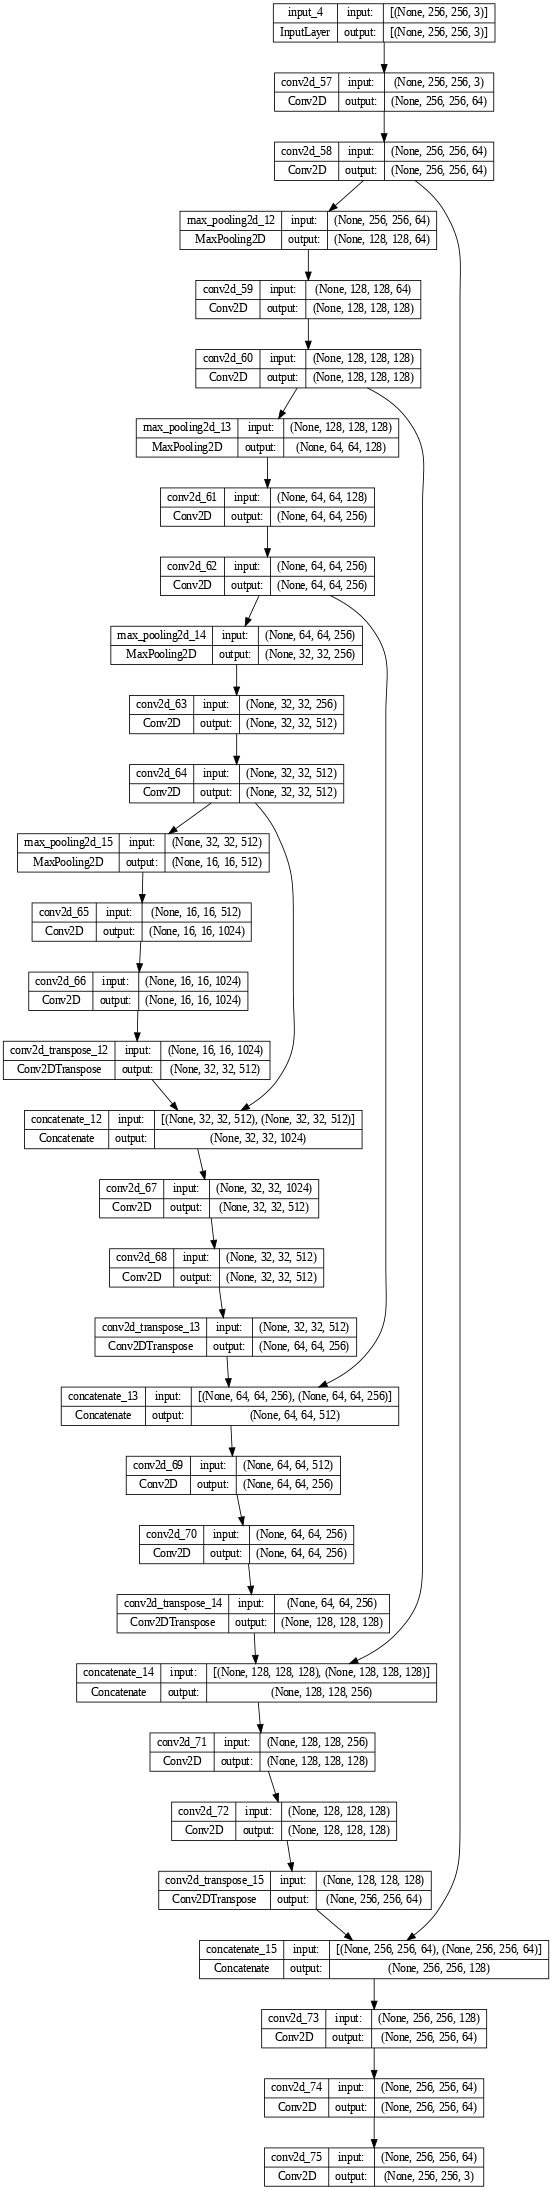

In [ ]:
from tensorflow.keras.utils import plot_model
# 모델 구조 시각화
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True, dpi=60)


#### Train

**코드 설명**
   - `batch_size=32`: 배치 크기는 32로 설정
   - `epochs=40`: 총 40 에포크 동안 훈련
   - `loss` : sparse_categorical_crossentropy
   - `learning rate` = 3e-4
   - `metrics` = accuracy
   - `classes` = 3 (상의, 하의, 배경)





In [ ]:
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_masks, batch_size=32)
val_generator = val_datagen.flow(val_images, val_masks, batch_size=32)

checkpoint = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_freq='epoch'
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=40,
    steps_per_epoch=len(train_images) // 32,
    validation_steps=len(val_images) // 32,
    callbacks=[checkpoint]
)

model.save('final_model.h5')


Epoch 1/40
377/377 [==============================] - ETA: 0s - loss: 0.4159 - accuracy: 0.8291
Epoch 1: saving model to model_epoch_01.h5
377/377 [==============================] - 564s 1s/step - loss: 0.4159 - accuracy: 0.8291 - val_loss: 0.3575 - val_accuracy: 0.8537
Epoch 2/40
377/377 [==============================] - ETA: 0s - loss: 0.3075 - accuracy: 0.8772
Epoch 2: saving model to model_epoch_02.h5
377/377 [==============================] - 565s 1s/step - loss: 0.3075 - accuracy: 0.8772 - val_loss: 0.2889 - val_accuracy: 0.8879
Epoch 3/40
377/377 [==============================] - ETA: 0s - loss: 0.2598 - accuracy: 0.8972
Epoch 3: saving model to model_epoch_03.h5
377/377 [==============================] - 565s 1s/step - loss: 0.2598 - accuracy: 0.8972 - val_loss: 0.2617 - val_accuracy: 0.9000
Epoch 4/40
377/377 [==============================] - ETA: 0s - loss: 0.2268 - accuracy: 0.9105
Epoch 4: saving model to model_epoch_04.h5
377/377 [==============================] - 564s 

KeyboardInterrupt: 

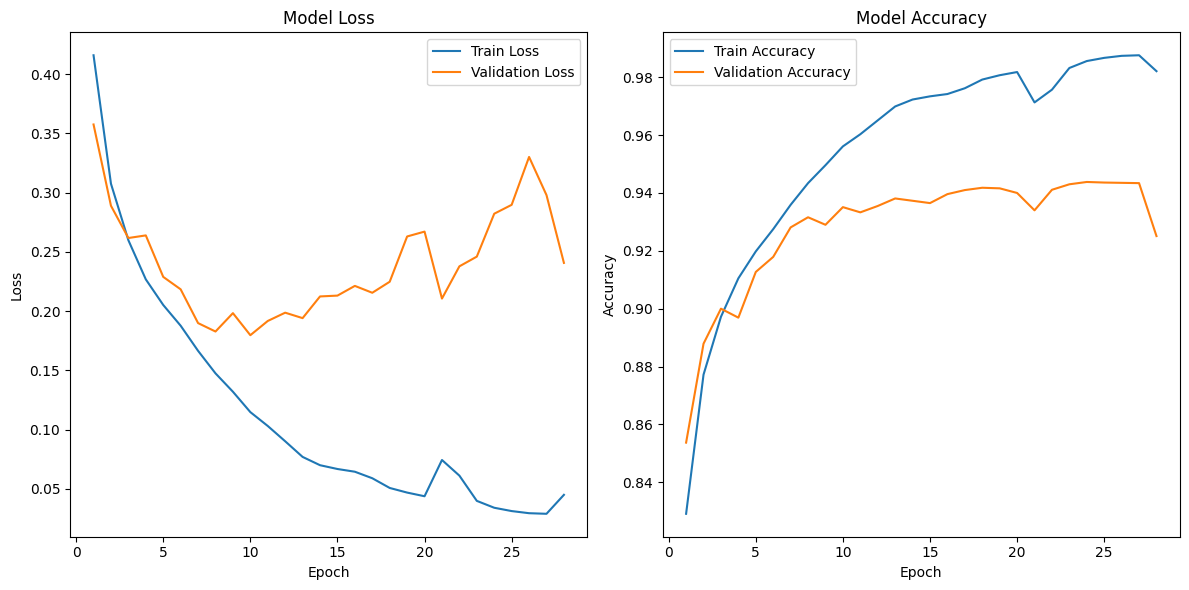

### Develop


주요 차이점

1. **컨볼루션 필터 수**:
    - `unet_model`: 각 레벨에서 64개의 필터로 시작하여 128, 256, 512, 1024로 증가
    - `unet_model2`: 각 레벨에서 32개의 필터로 시작하여 64, 128, 256, 512로 증가 필터 수가 절반으로 시작하여 모델의 복잡도가 상대적으로 낮음.

2. **Batch Normalization**:
    - `unet_model`: Batch Normalization을 사용하지 않음.
    - `unet_model2`: 각 컨볼루션 레이어 뒤에 Batch Normalization을 추가하여 학습을 안정화하고 성능을 향상시킴.

3. **Dropout 레이어**:
    - `unet_model`: Dropout 레이어를 사용하지 않음.
    - `unet_model2`: 각 MaxPooling 레이어 뒤에 Dropout(0.5)을 추가하여 모델이 과적합되는 것을 방지

4. **디코더 필터 수**:
    - `unet_model`: 디코더 단계에서 필터 수가 512, 256, 128, 64로 줄어듬
    - `unet_model2`: 디코더 단계에서 필터 수가 256, 128, 64, 32로 줄어듬

일반화 성능을 높이기 위해
- `unet_model2`는 더 낮은 파라미터 수와 과적합 방지를 위한 추가 기법(Batch Normalization과 Dropout)을 포함
-   `unet_model`은 더 높은 필터 수와 단순한 구조를 가지고 있어 더 많은 특징을 추출할 수 있지만, 과적합될 가능성이 더 높음.

In [ ]:
def unet_model2(input_size=(256, 256, 3), num_classes=3):
    inputs = layers.Input(input_size)

    # 인코더
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.5)(p1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.5)(p2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.5)(p3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(0.5)(p4)

    # 중심
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)

    # 디코더
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.BatchNormalization()(c8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    c8 = layers.BatchNormalization()(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.BatchNormalization()(c9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

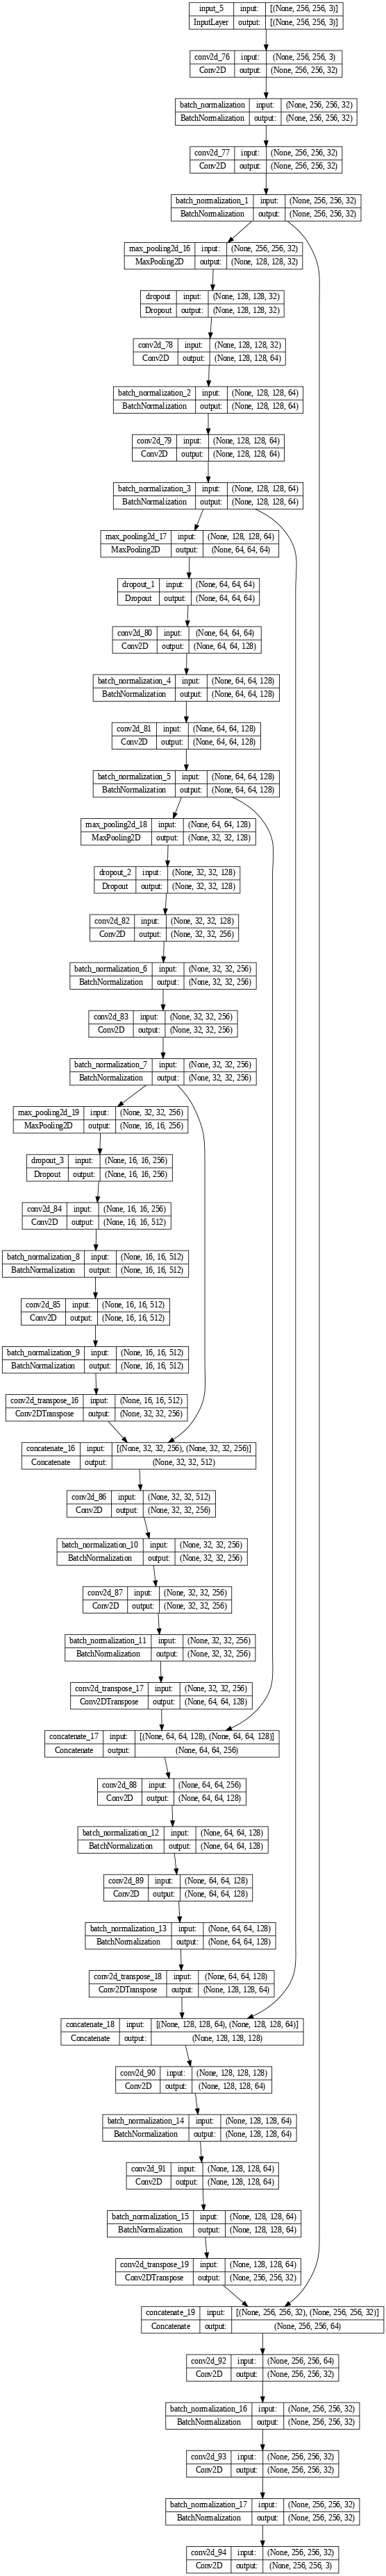

In [ ]:
model2 = unet_model2(input_size, num_classes)

# 모델 구조 시각화
plot_model(model2, to_file='unet_model.png', show_shapes=True, show_layer_names=True, dpi=60)


In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy', iou_metric])

# 체크포인트 설정
checkpoint = ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_freq='epoch'
)

# 모델 학습
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    steps_per_epoch=train_size // batch_size,
    validation_steps=val_size // batch_size,
    callbacks=[checkpoint]
)

# 최종 모델 저장
model.save('final_model.h5')


Epoch 1/40
377/377 [==============================] - ETA: 0s - loss: 0.7774 - accuracy: 0.7669 - iou_metric: 1.3471
Epoch 1: saving model to model_epoch_01.h5
377/377 [==============================] - 296s 708ms/step - loss: 0.7774 - accuracy: 0.7669 - iou_metric: 1.3471 - val_loss: 0.7863 - val_accuracy: 0.7813 - val_iou_metric: 0.8139
Epoch 2/40
377/377 [==============================] - ETA: 0s - loss: 0.5443 - accuracy: 0.8446 - iou_metric: 1.8502
Epoch 2: saving model to model_epoch_02.h5
377/377 [==============================] - 274s 713ms/step - loss: 0.5443 - accuracy: 0.8446 - iou_metric: 1.8502 - val_loss: 0.5683 - val_accuracy: 0.8161 - val_iou_metric: 0.9486
Epoch 3/40
377/377 [==============================] - ETA: 0s - loss: 0.4439 - accuracy: 0.8627 - iou_metric: 2.2362
Epoch 3: saving model to model_epoch_03.h5
377/377 [==============================] - 278s 722ms/step - loss: 0.4439 - accuracy: 0.8627 - iou_metric: 2.2362 - val_loss: 0.4820 - val_accuracy: 0.8552 - 

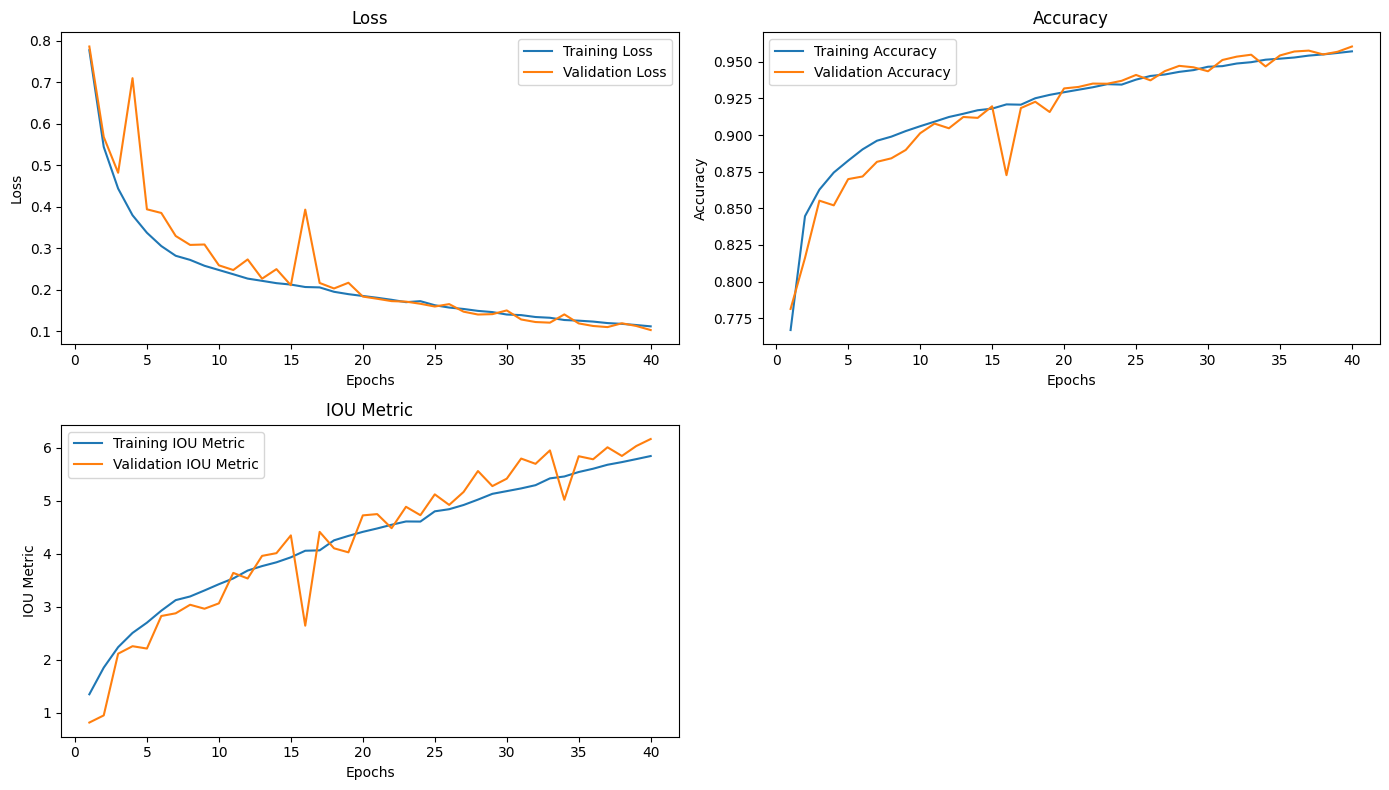

### 시각화
 -  정성적 평가 결과, 처음 학습 했던 UNET이 낫다고 판단, unet1의 epoch 10 모델 선정

1/1 [==============================] - 0s 185ms/step


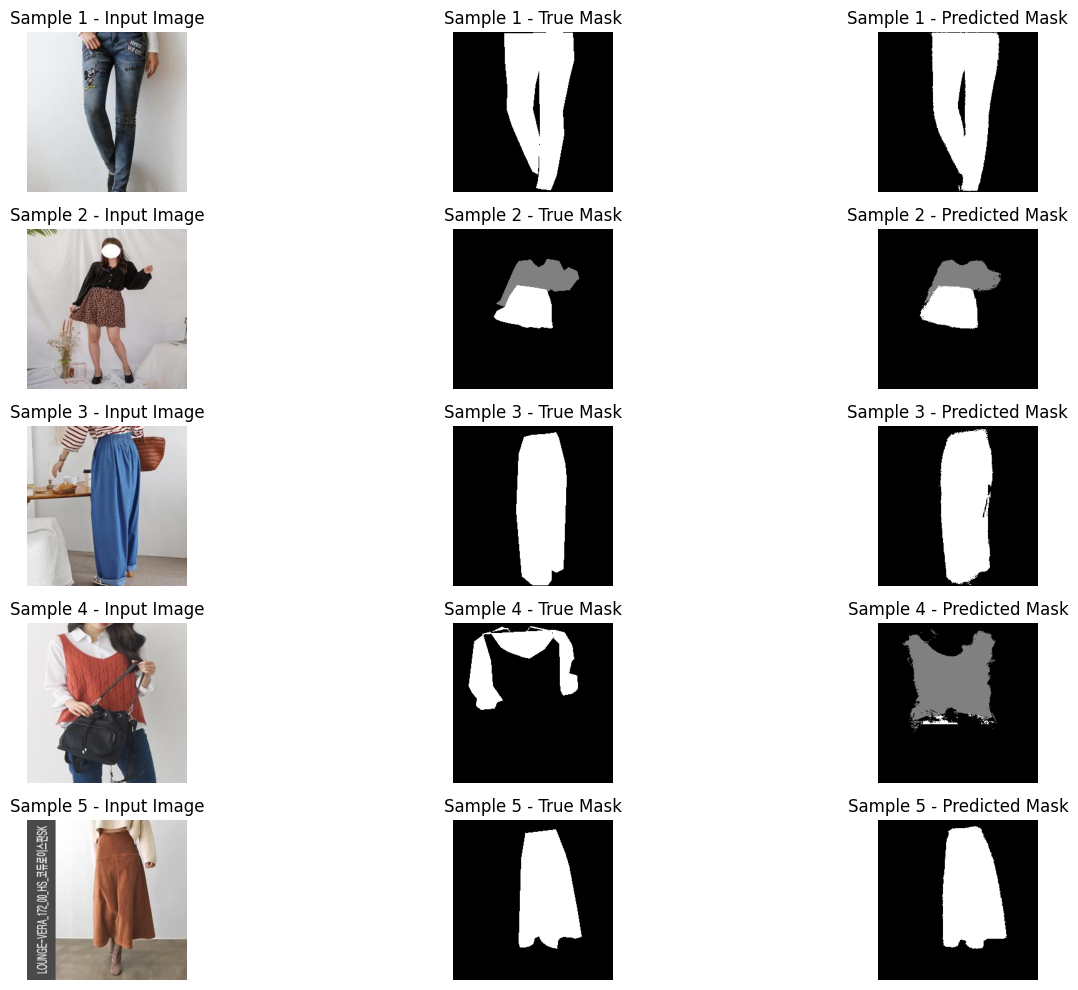

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the model from epoch 11
model = load_model('model_epoch_10.h5')

# Number of samples to visualize
num_samples = 5

# Select random samples from the validation set
indices = np.random.choice(len(val_images), num_samples, replace=False)
selected_images = val_images[indices]
selected_masks = val_masks[indices]

# Make predictions
predicted_masks = model.predict(selected_images)
predicted_masks = np.argmax(predicted_masks, axis=-1)

# Plotting the results
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    image = selected_images[i]
    true_mask = selected_masks[i]
    pred_mask = predicted_masks[i]

    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.title(f"Sample {i+1} - Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.title(f"Sample {i+1} - True Mask")
    plt.imshow(true_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.title(f"Sample {i+1} - Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 192ms/step


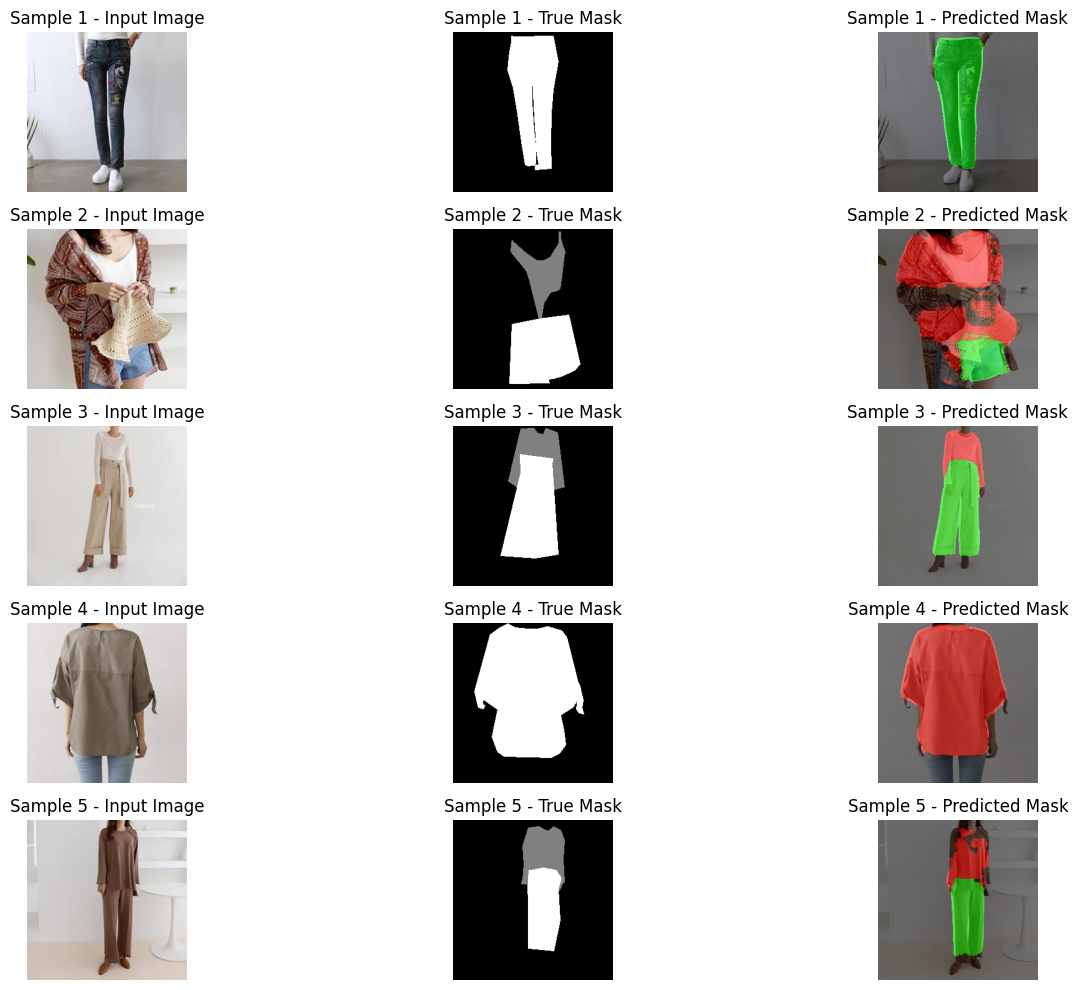

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import cv2

# Load the model from epoch 11
model = load_model('model_epoch_10.h5')

# Number of samples to visualize
num_samples = 5

# Select random samples from the validation set
indices = np.random.choice(len(val_images), num_samples, replace=False)
selected_images = val_images[indices]
selected_masks = val_masks[indices]

# Make predictions
predicted_masks = model.predict(selected_images)
predicted_masks = np.argmax(predicted_masks, axis=-1)

def overlay_mask(image, mask, alpha=0.5):
    color_mask = np.zeros_like(image)
    color_mask[mask == 1] = [255, 0, 0]  # Color for class 1 (e.g., upper body)
    color_mask[mask == 2] = [0, 255, 0]  # Color for class 2 (e.g., lower body)

    overlayed_image = cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)
    return overlayed_image

# Plotting the results
plt.figure(figsize=(15, 10))

for i in range(num_samples):
    image = selected_images[i]
    true_mask = selected_masks[i]
    pred_mask = predicted_masks[i]

    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.title(f"Sample {i+1} - Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.title(f"Sample {i+1} - True Mask")
    plt.imshow(true_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.title(f"Sample {i+1} - Predicted Mask")
    overlayed_image = overlay_mask(image, pred_mask)
    plt.imshow(overlayed_image)
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 174ms/step


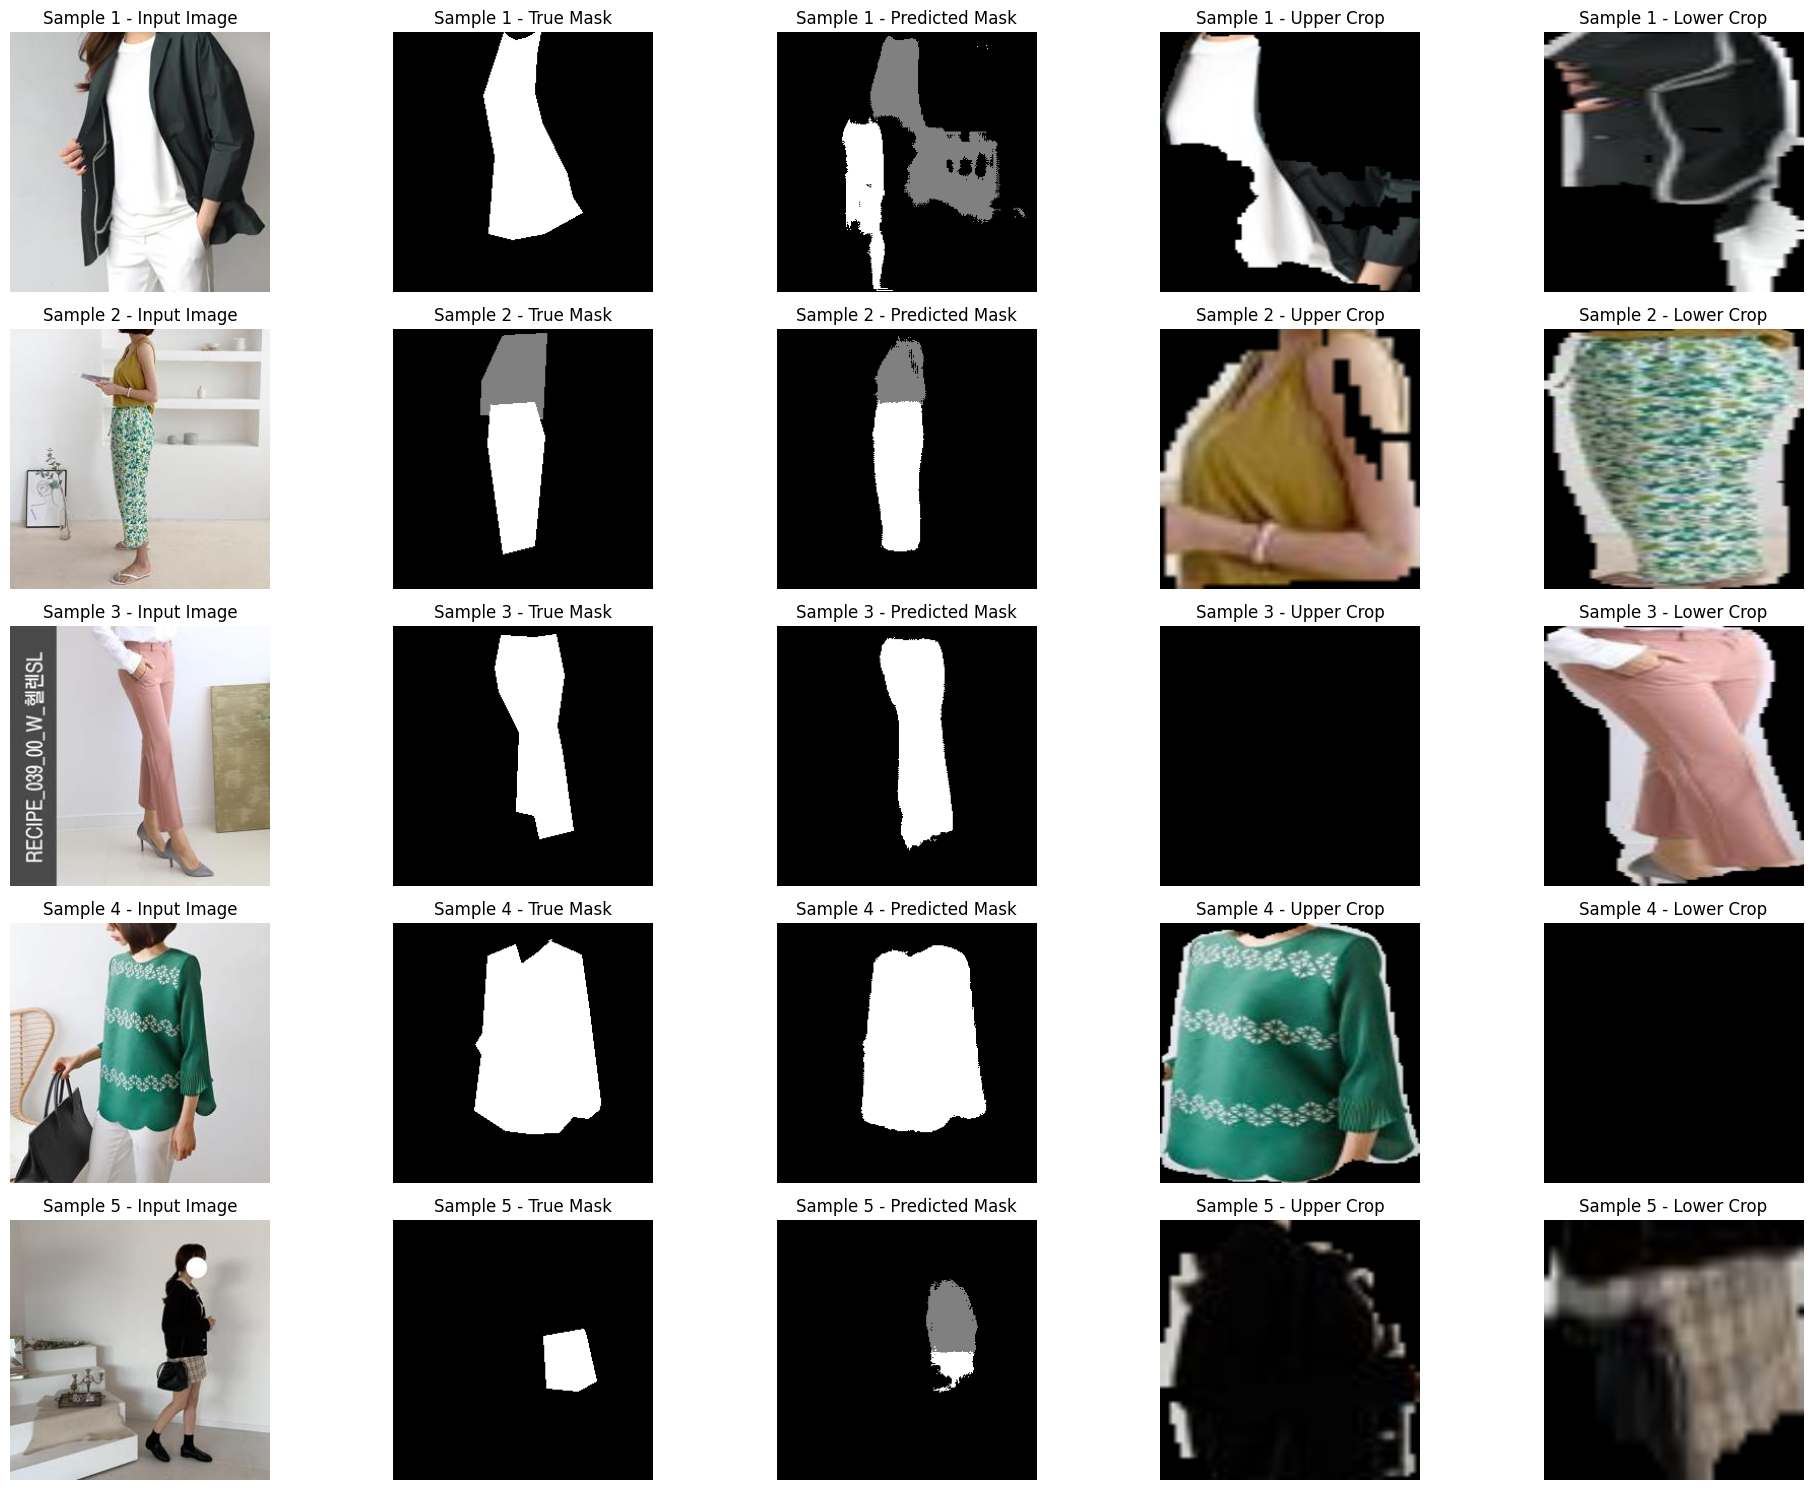

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def extract_and_crop(image, mask, class_id, target_size=(256, 256)):
    """
    이미지와 마스크에서 특정 클래스를 크롭하고, 크롭된 이미지를 타겟 크기로 리사이즈합니다.

    Parameters:
    image (np.array): 원본 이미지.
    mask (np.array): 예측된 마스크.
    class_id (int): 크롭할 클래스의 ID (예: 1은 상의, 2는 하의).
    target_size (tuple): 리사이즈할 타겟 크기 (기본값: (256, 256)).

    Returns:
    cropped_image (np.array): 크롭된 이미지.
    """
    # 해당 클래스의 마스크 추출
    class_mask = (mask == class_id).astype(np.uint8)

    # 노이즈 제거를 위한 모폴로지 연산 (열기 연산)
    kernel = np.ones((5, 5), np.uint8)
    class_mask = cv2.morphologyEx(class_mask, cv2.MORPH_OPEN, kernel)

    # 연결된 컴포넌트를 찾아 경계 상자 계산
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(class_mask, connectivity=8)

    # 가장 큰 연결 컴포넌트의 경계 상자 추출 (0번 레이블은 배경이므로 제외)
    if num_labels > 1:  # Ensure there are connected components detected
        largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        x, y, w, h = stats[largest_component, cv2.CC_STAT_LEFT], stats[largest_component, cv2.CC_STAT_TOP], stats[largest_component, cv2.CC_STAT_WIDTH], stats[largest_component, cv2.CC_STAT_HEIGHT]

        # 원본 이미지에서 해당 영역 크롭
        cropped_image = image[y:y+h, x:x+w]

        # 마스크된 원본 이미지 생성
        masked_image = cv2.bitwise_and(cropped_image, cropped_image, mask=class_mask[y:y+h, x:x+w])

        # 타겟 크기로 리사이즈
        resized_image = cv2.resize(masked_image, target_size, interpolation=cv2.INTER_LINEAR)

        return resized_image
    else:
        return np.zeros((*target_size, 3), dtype=np.uint8)  # Return an empty image if no components are found

# Load the model from epoch 11
model = load_model('model_epoch_11.h5')

# Number of samples to visualize
num_samples = 5

# Select random samples from the validation set
indices = np.random.choice(len(val_images), num_samples, replace=False)
selected_images = val_images[indices]
selected_masks = val_masks[indices]

# Make predictions
predicted_masks = model.predict(selected_images)
predicted_masks = np.argmax(predicted_masks, axis=-1)

# Plotting the results
plt.figure(figsize=(20, 15))

for i in range(num_samples):
    image = selected_images[i]
    true_mask = selected_masks[i]
    pred_mask = predicted_masks[i]

    # 상의 크롭
    upper_crop = extract_and_crop(image, pred_mask, class_id=1)
    # 하의 크롭
    lower_crop = extract_and_crop(image, pred_mask, class_id=2)

    plt.subplot(num_samples, 5, i * 5 + 1)
    plt.title(f"Sample {i+1} - Input Image")
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(num_samples, 5, i * 5 + 2)
    plt.title(f"Sample {i+1} - True Mask")
    plt.imshow(true_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(num_samples, 5, i * 5 + 3)
    plt.title(f"Sample {i+1} - Predicted Mask")
    plt.imshow(pred_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(num_samples, 5, i * 5 + 4)
    plt.title(f"Sample {i+1} - Upper Crop")
    plt.imshow(upper_crop)
    plt.axis('off')

    plt.subplot(num_samples, 5, i * 5 + 5)
    plt.title(f"Sample {i+1} - Lower Crop")
    plt.imshow(lower_crop)
    plt.axis('off')

plt.tight_layout()
plt.show()


## Feature Extraction
---

### 목적


*   segmentation 모델에서 출력된 상의 크롭 이미지에 대해서 'color'와 'style' 속성이 같은 데이터들에 대해서만 유사도 분석을 진행하기 위해서 사용합니다.
  *  입력된 상의와 모든 이미지를 비교하는 건 비효율적이기 때문입니다.  



### Use Data


*   다양한 조합의 하이퍼 파라미터를 선정하기 위해서 클래스를 균등하게 추출한 1500개의 토이 데이터 셋을 이용했습니다.
  * 클래스는 총 5가지 [셔츠, 탑, 니트, 티셔츠, 블라우스]
*   최종 모델에서는 최고 성능을 위해서 90000개의 데이터셋에서 train과 validation을 나눠서 사용했습니다.



### Model Architecture


1.   backbone : resNet vs VGG16
2. architecture : mlp 시작에서 multi head 생성 vs 출력 레이어에서 multi head 생성
  * 멀티 아웃풋 모델이므로 무조건 multi head가 생길 수 밖에 없는데 이 지점을 어디로 설정하는가?

*  **위 두 가지 조건을 조합한 4가지 경우의 수를 비교했습니다.**

*  **"VGG + mlp에서 multi head 생성 모델"의 성능이 제일 높았습니다.**




In [ ]:
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
# vgg_model + add.layer
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(5, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer='adam', loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)


history4=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_VGG_2.h5')

Epoch 1/100


<ipython-input-25-41ed10a76bba>:30: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4=model.fit_generator(training_set,


20/19 [===============================] - ETA: 0s - loss: 6.3921 - style_loss: 2.3172 - color_loss: 4.0750 - style_accuracy: 0.2719 - color_accuracy: 0.0766
Epoch 1: val_loss improved from inf to 7.61567, saving model to feature_extraction_VGG_2.h5
19/19 [==============================] - 9s 373ms/step - loss: 6.3921 - style_loss: 2.3172 - color_loss: 4.0750 - style_accuracy: 0.2719 - color_accuracy: 0.0766 - val_loss: 7.6157 - val_style_loss: 3.1847 - val_color_loss: 4.4309 - val_style_accuracy: 0.2719 - val_color_accuracy: 0.1344
Epoch 2/100
20/19 [===============================] - ETA: 0s - loss: 5.8603 - style_loss: 2.1661 - color_loss: 3.6942 - style_accuracy: 0.2672 - color_accuracy: 0.1195
Epoch 2: val_loss improved from 7.61567 to 4.92643, saving model to feature_extraction_VGG_2.h5
19/19 [==============================] - 7s 345ms/step - loss: 5.8603 - style_loss: 2.1661 - color_loss: 3.6942 - style_accuracy: 0.2672 - color_accuracy: 0.1195 - val_loss: 4.9264 - val_style_loss

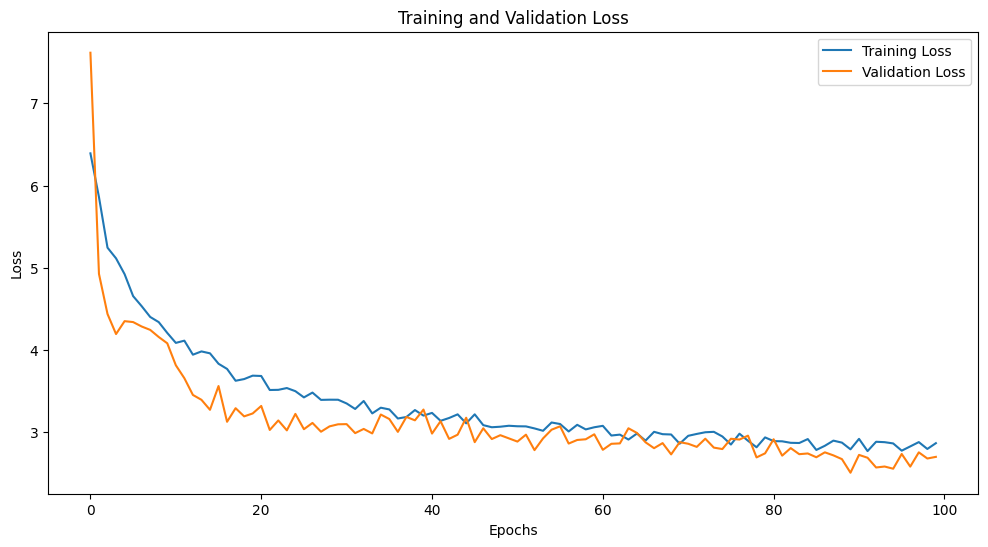

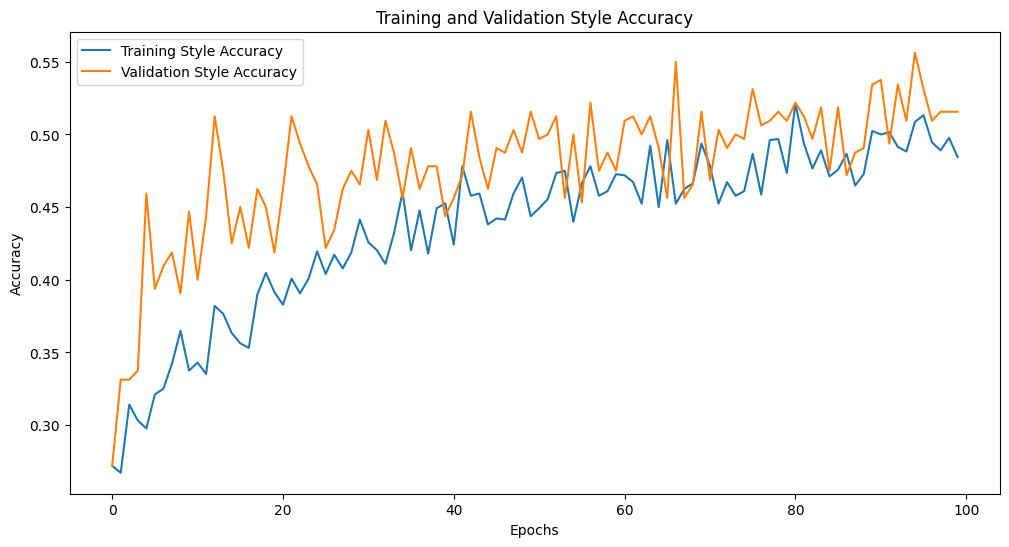

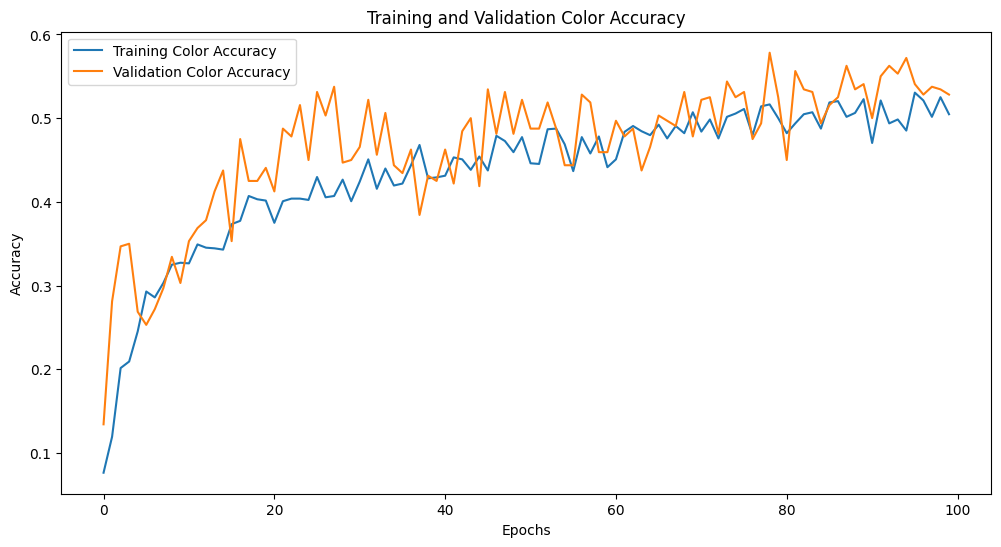

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history4)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history4)

# 색상 예측 정확도 시각화
plot_color_accuracy(history4)

### optimizer

*   Nadam, AdamW, Adam 비교, Nadam에서 성능이 제일 좋음
  * Nadam = Adam + Nesterov : 학습 속도를 높이고 안정성을 개선
  * AdamW = Adam + 가중치 감쇠 : 학습 과정에서 가중치 감쇠를 올바르게 적용하기 위해 도입된 방식

In [ ]:
# Nadam 사용
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Nadam(learning_rate = 3e-4), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

Epoch 1/100


<ipython-input-16-0db558e6e44d>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


20/19 [===============================] - ETA: 0s - loss: 6.9864 - style_loss: 2.8510 - color_loss: 4.1353 - style_accuracy: 0.1844 - color_accuracy: 0.0750
Epoch 1: val_loss improved from inf to 5.38659, saving model to feature_extraction_VGG_2.h5
19/19 [==============================] - 11s 370ms/step - loss: 6.9864 - style_loss: 2.8510 - color_loss: 4.1353 - style_accuracy: 0.1844 - color_accuracy: 0.0750 - val_loss: 5.3866 - val_style_loss: 1.8937 - val_color_loss: 3.4929 - val_style_accuracy: 0.1969 - val_color_accuracy: 0.1187
Epoch 2/100
20/19 [===============================] - ETA: 0s - loss: 6.4702 - style_loss: 2.6136 - color_loss: 3.8567 - style_accuracy: 0.2117 - color_accuracy: 0.1273
Epoch 2: val_loss improved from 5.38659 to 5.14560, saving model to feature_extraction_VGG_2.h5
19/19 [==============================] - 7s 343ms/step - loss: 6.4702 - style_loss: 2.6136 - color_loss: 3.8567 - style_accuracy: 0.2117 - color_accuracy: 0.1273 - val_loss: 5.1456 - val_style_los

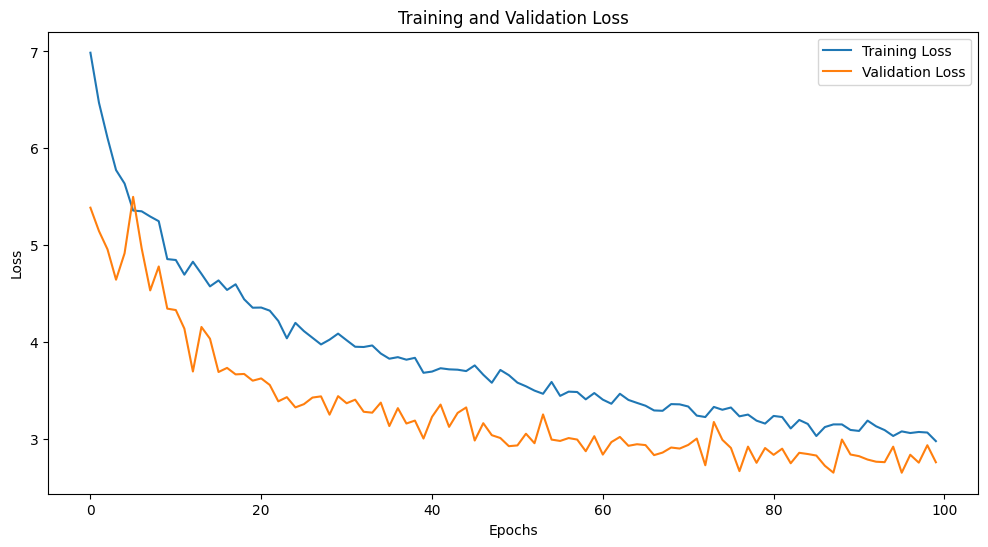

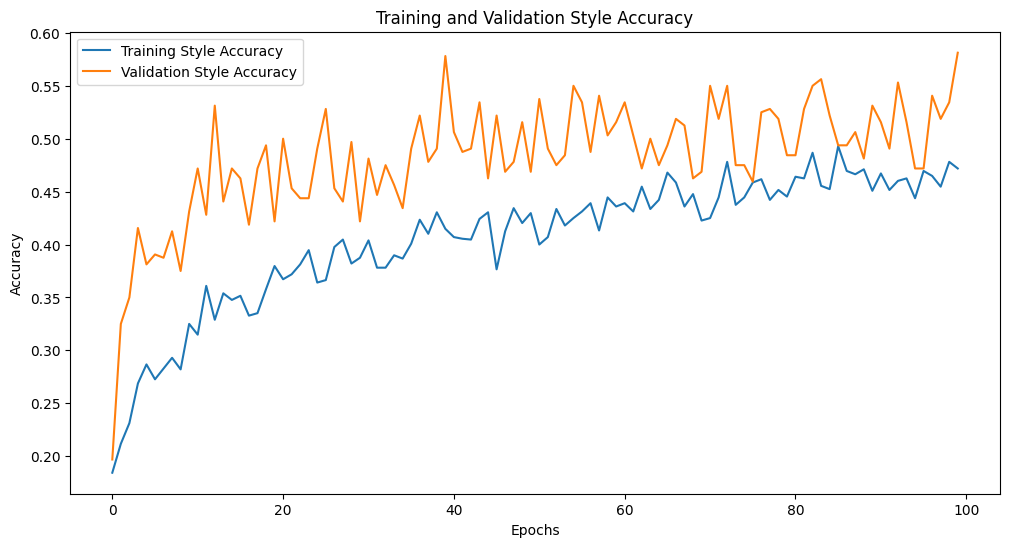

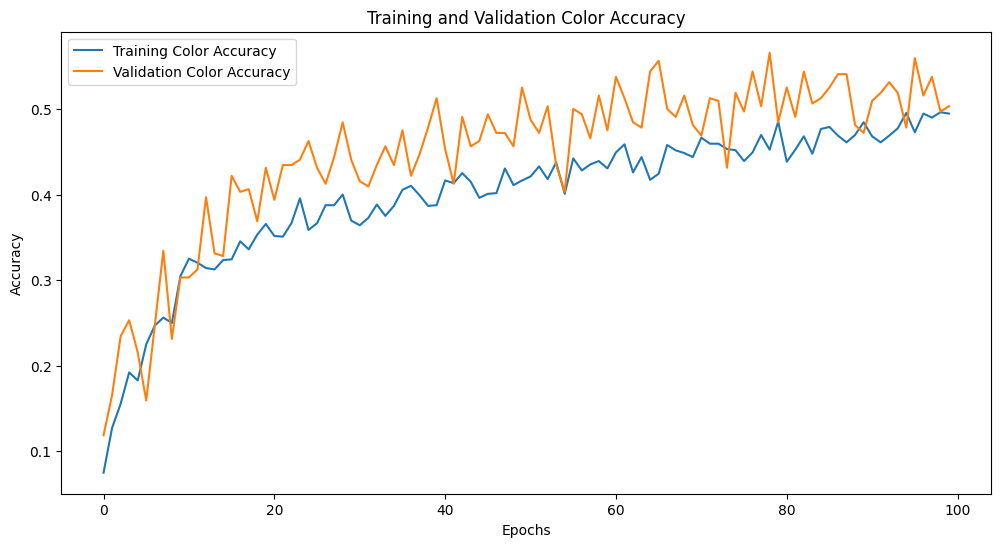

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

### epoch


*   앞선 하이퍼 파라미터 결정 과정에서 확인 가능한 것처럼 비교적 이른 에폭에서 성능이 급격히 상승, 이후에는 천천히 지속적으로 상승하는 모양을 보입니다.
*   에폭 값을 계속 올려도 최적이라고 하기에 애매합니다.
  *   모델 구조에 비해서(pretrain + mlp) 큰 에폭을 설정하고 early_stoping을 설정했습니다
  *   80 에폭 정도에서 정지하는 것을 보아 적당하다고 판단했습니다.





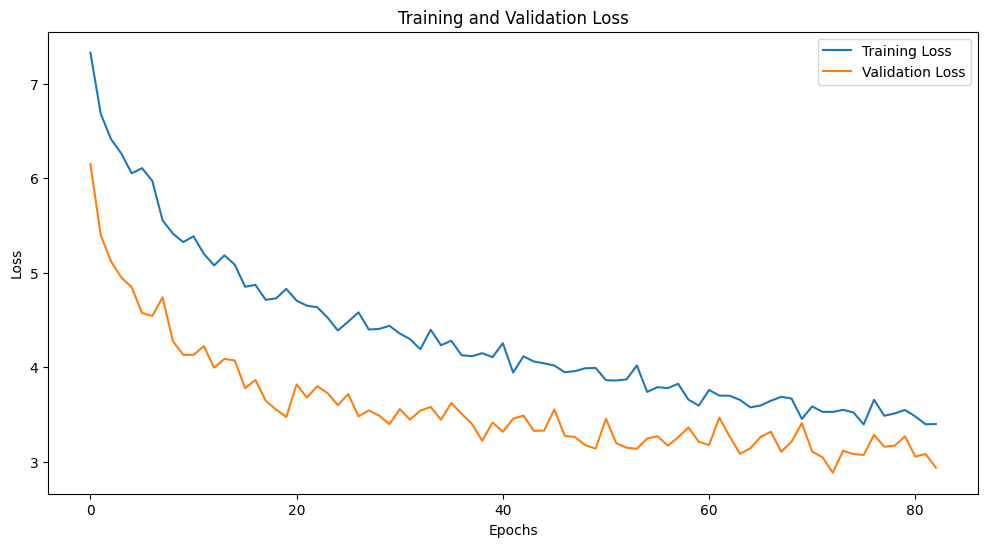

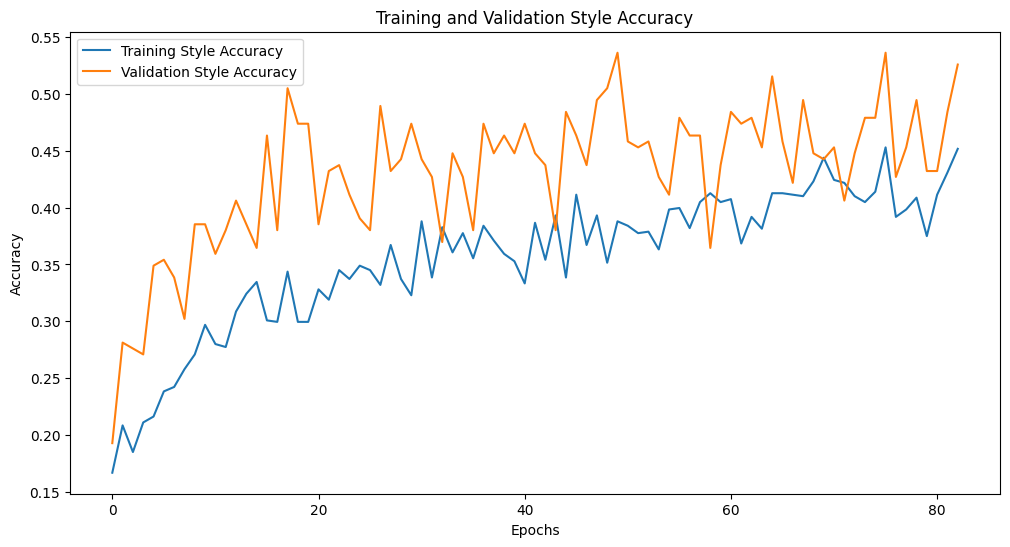

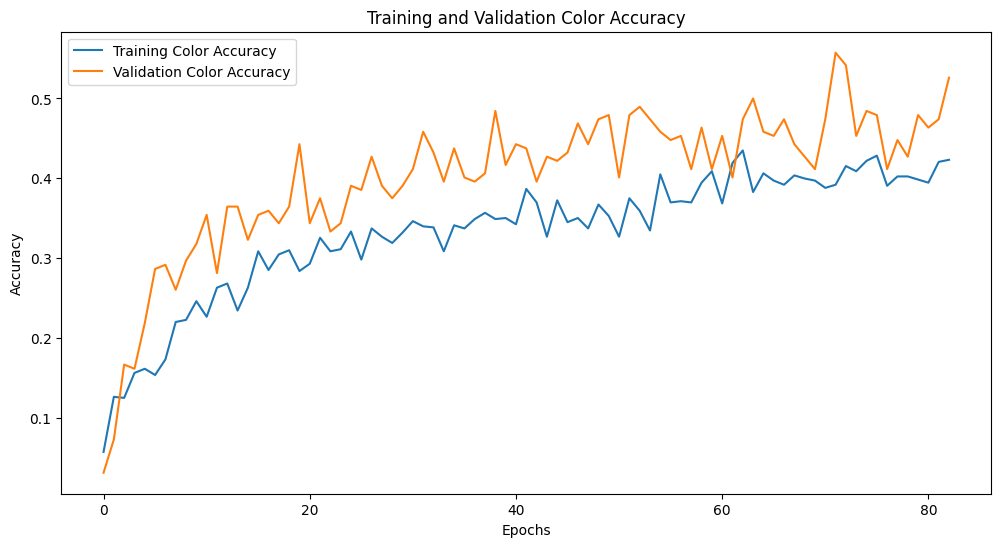

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

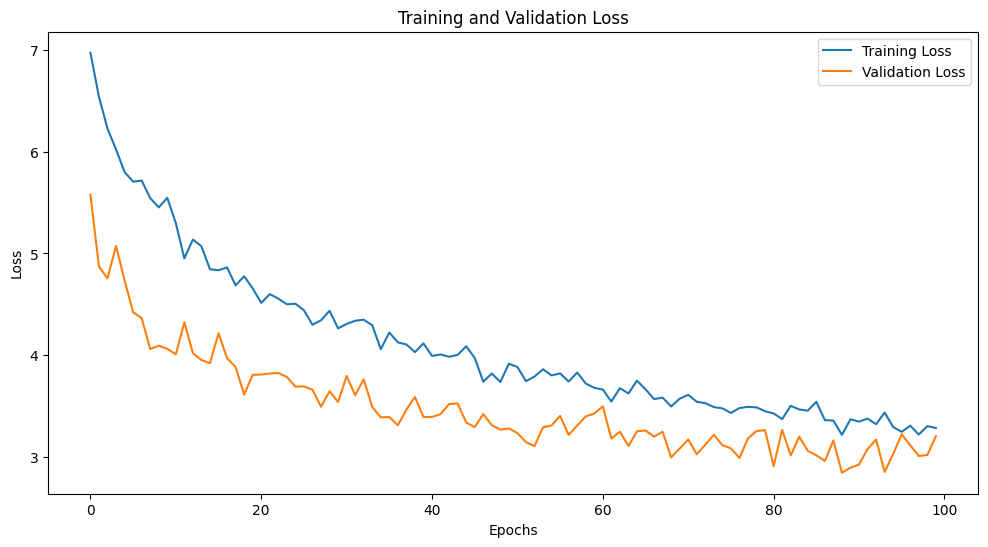

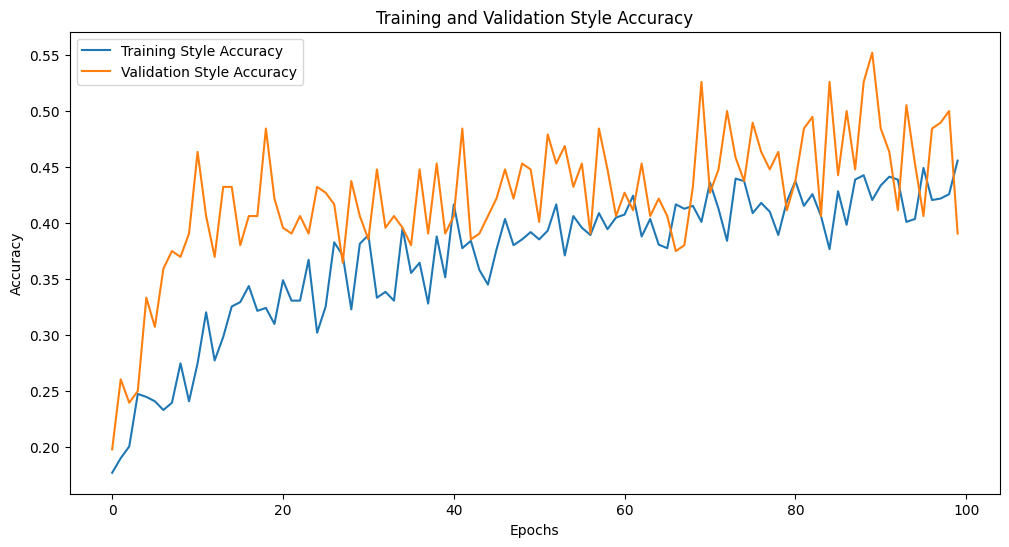

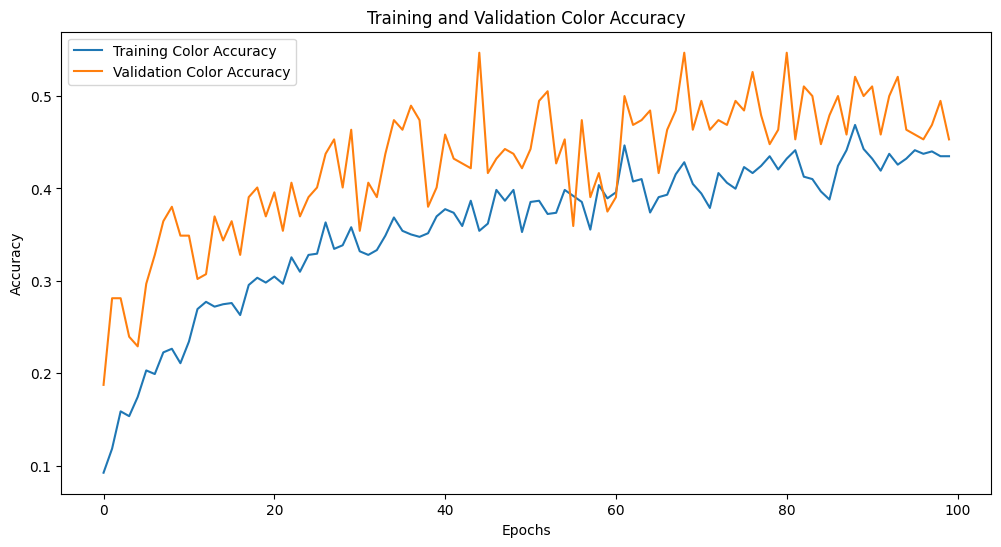

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

### learning_rate


*   고정된 학습률 : 0.01, 0.001, 0.0001, 3e-4
*   reduce_learning_rate(하한 0 or 3e-5)
  * ReduceLROnPlateau 사용
  * 시작은 0.1부터

**총 6가지의 경우의 수를 비교했습니다.**  
**고정된 3e-4를 사용할 때 성능이 가장 높았습니다.**





In [ ]:
# 학습률 초기값 3e-4
vgg_model = VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = layers.Flatten(name='new_flatten')(x)
branch_a=layers.Dense(units=256)(x)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Activation('relu')(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)
branch_a=layers.Dense(units=128)(branch_a)
branch_a=layers.BatchNormalization()(branch_a)
branch_a=layers.Dropout(0.5)(branch_a)

style_prediction = layers.Dense(7, activation='softmax', name='style')(branch_a)
color_prediction = layers.Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input,[style_prediction, color_prediction])
model.compile(optimizer=Adam(learning_rate = 3e-4), loss={'style':'sparse_categorical_crossentropy','color':'sparse_categorical_crossentropy'}, metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history1=model.fit_generator(training_set,
                         epochs = 100,
                         validation_data = test_set,
                         callbacks=[checkpoint_callback],
                         steps_per_epoch=len(training_set)/batch_size,
                         validation_steps=len(test_set)/batch_size
                        )

# model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop.h5')

<ipython-input-15-46d5ff4787c7>:41: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1=model.fit_generator(training_set,


Epoch 1/100
6/5 [==============================] - ETA: 0s - loss: 7.6246 - style_loss: 3.1628 - color_loss: 4.4619 - style_accuracy: 0.1562 - color_accuracy: 0.0677
Epoch 1: val_loss improved from inf to 5.33870, saving model to feature_extraction_VGG_2.h5
5/5 [==============================] - 7s 758ms/step - loss: 7.6246 - style_loss: 3.1628 - color_loss: 4.4619 - style_accuracy: 0.1562 - color_accuracy: 0.0677 - val_loss: 5.3387 - val_style_loss: 2.0434 - val_color_loss: 3.2953 - val_style_accuracy: 0.1641 - val_color_accuracy: 0.0859
Epoch 2/100
6/5 [==============================] - ETA: 0s - loss: 7.0805 - style_loss: 2.8505 - color_loss: 4.2300 - style_accuracy: 0.1979 - color_accuracy: 0.0807
Epoch 2: val_loss did not improve from 5.33870
5/5 [==============================] - 3s 462ms/step - loss: 7.0805 - style_loss: 2.8505 - color_loss: 4.2300 - style_accuracy: 0.1979 - color_accuracy: 0.0807 - val_loss: 5.7433 - val_style_loss: 2.2127 - val_color_loss: 3.5306 - val_style_a

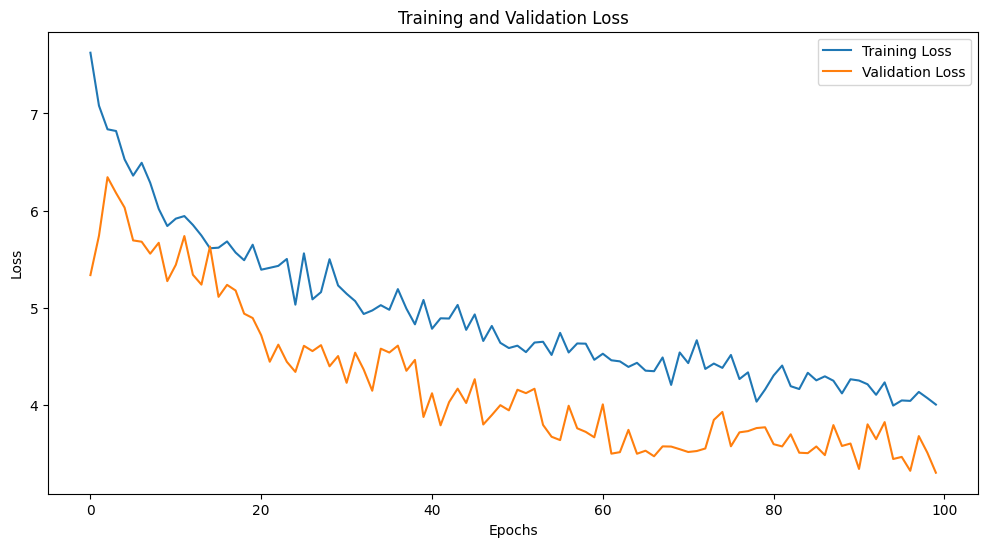

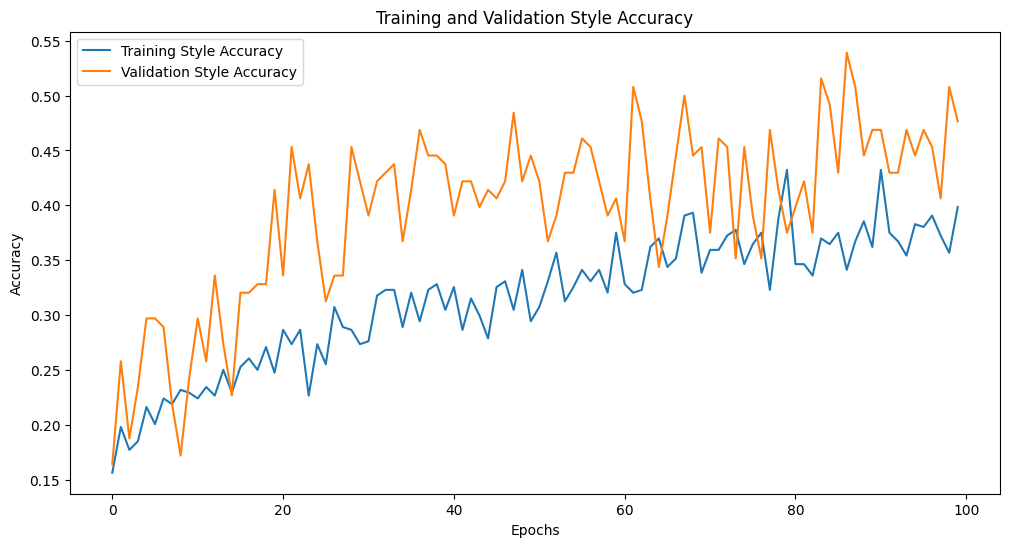

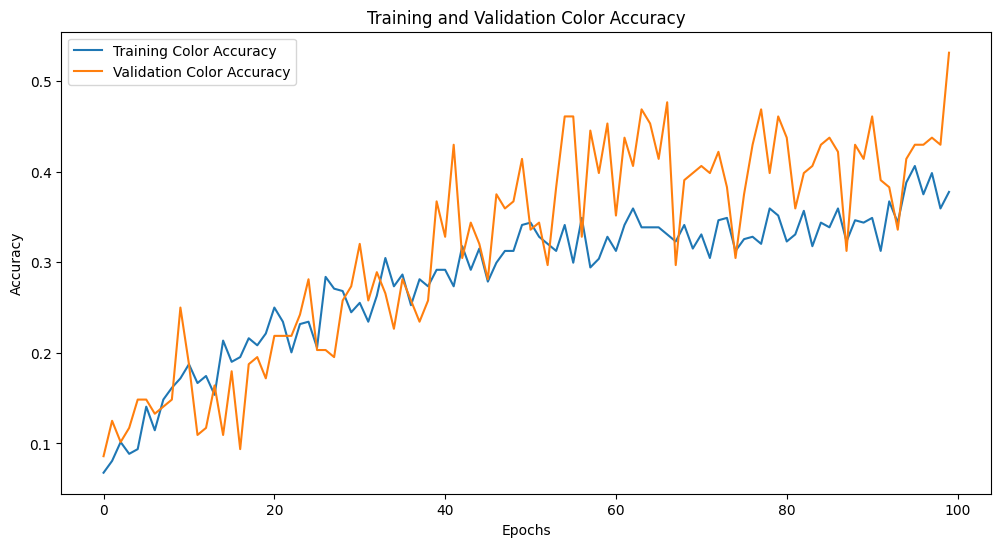

In [ ]:
import matplotlib.pyplot as plt

# 학습 과정에서의 손실을 시각화하는 함수
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 학습 과정에서의 스타일 예측 정확도를 시각화하는 함수
def plot_style_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['style_accuracy'], label='Training Style Accuracy')
    plt.plot(history.history['val_style_accuracy'], label='Validation Style Accuracy')
    plt.title('Training and Validation Style Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 학습 과정에서의 색상 예측 정확도를 시각화하는 함수
def plot_color_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['color_accuracy'], label='Training Color Accuracy')
    plt.plot(history.history['val_color_accuracy'], label='Validation Color Accuracy')
    plt.title('Training and Validation Color Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# 손실 시각화
plot_loss(history1)

# 스타일 예측 정확도 시각화
plot_style_accuracy(history1)

# 색상 예측 정확도 시각화
plot_color_accuracy(history1)

### Final feature extraction model


*  위에서 찾은 hyper parameter와 architecture를 이용해서 full data set을 이용해서 학습시켰을 때 성능이 너무 낮은 문제에 직면
<img src = "https://drive.google.com/uc?id=1FRURVj1A61AiWK3CruZWLn6Rsd3jPlja" height = 500 width = 800>
*   낮은 에폭 수준에서 성능 향상이 더 이상 일어나지 않는 것을 확인하고, 모델 architecture 변경
*   color와 style에 대한 모델을 별도로 생성,각각 Model evaluate 결과 확인
  * color :  66%
  * style :  60%


*   변경 전에는 55%를 넘지 못하던 결과에 비해 유의미한 성능 향상







In [ ]:
# color 모델 정의
vgg_model = VGG16(weights='imagenet', input_shape=(256, 256, 3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = Flatten(name='new_flatten')(x)
branch_a = Dense(units=256)(x)
branch_a = BatchNormalization()(branch_a)
branch_a = Activation('relu')(branch_a)
branch_a = Dropout(0.5)(branch_a)
branch_a = Dense(units=128)(branch_a)
branch_a = BatchNormalization()(branch_a)
branch_a = Dropout(0.5)(branch_a)

style_prediction = Dense(21, activation='softmax', name='color')(branch_a)

model = Model(vgg_model.input, style_prediction)
model.compile(optimizer=Nadam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1
)

# 학습률 감소 콜백 설정
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# 모델 훈련
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback, lr_scheduler]
)

# 모델 저장
model.save_weights('/content/gdrive/MyDrive/Colab Notebooks/딥러닝/dl_project/feature_extraction_hyperParemeter_earlyStop_color.h5')


Epoch 1/100
1231/1232 [============================>.] - ETA: 0s - loss: 2.1117 - accuracy: 0.4189
Epoch 1: val_accuracy improved from -inf to 0.56017, saving model to feature_extraction_VGG_2.h5
1232/1232 [==============================] - 109s 85ms/step - loss: 2.1115 - accuracy: 0.4189 - val_loss: 1.4183 - val_accuracy: 0.5602 - lr: 3.0000e-04
Epoch 2/100
1231/1232 [============================>.] - ETA: 0s - loss: 1.5171 - accuracy: 0.5329
Epoch 2: val_accuracy improved from 0.56017 to 0.59727, saving model to feature_extraction_VGG_2.h5
1232/1232 [==============================] - 105s 85ms/step - loss: 1.5169 - accuracy: 0.5329 - val_loss: 1.2554 - val_accuracy: 0.5973 - lr: 3.0000e-04
Epoch 3/100
1231/1232 [============================>.] - ETA: 0s - loss: 1.3368 - accuracy: 0.5798
Epoch 3: val_accuracy improved from 0.59727 to 0.62655, saving model to feature_extraction_VGG_2.h5
1232/1232 [==============================] - 105s 85ms/step - loss: 1.3368 - accuracy: 0.5798 - val_

KeyboardInterrupt: 

In [ ]:
model.evaluate(validation_dataset)

308/308 [==============================] - 19s 60ms/step - loss: 1.0479 - accuracy: 0.6639


[1.0478839874267578, 0.6639090776443481]

In [ ]:
# style 모델 정의
from keras.optimizers import Nadam
# 모델 정의
vgg_model = VGG16(weights='imagenet', input_shape=(256, 256, 3), include_top=False)
vgg_model.trainable = False
x = vgg_model.get_layer('block5_pool').output

x = Flatten(name='new_flatten')(x)
branch_a = Dense(units=256)(x)
branch_a = BatchNormalization()(branch_a)
branch_a = Activation('relu')(branch_a)
branch_a = Dropout(0.5)(branch_a)
branch_a = Dense(units=128)(branch_a)
branch_a = BatchNormalization()(branch_a)
branch_a = Dropout(0.5)(branch_a)

style_prediction = Dense(5, activation='softmax', name='style')(branch_a)

model = Model(vgg_model.input, style_prediction)
model.compile(optimizer=Nadam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    filepath='feature_extraction_VGG_2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    verbose=1
)

# 학습률 감소 콜백 설정
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# 모델 훈련
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback, early_stopping_callback, lr_scheduler]
)

# 모델 저장
model.save_weights('/content/gdrive/MyDrive/Deep_learning/team_project/feature_extraction_hyperParemeter_earlyStop_style_Nadam_5.h5')


Epoch 1/100
1231/1232 [============================>.] - ETA: 0s - loss: 1.5365 - accuracy: 0.4212
Epoch 1: val_accuracy improved from -inf to 0.53748, saving model to feature_extraction_VGG_2.h5
1232/1232 [==============================] - 109s 86ms/step - loss: 1.5364 - accuracy: 0.4212 - val_loss: 1.1482 - val_accuracy: 0.5375 - lr: 3.0000e-04
Epoch 2/100
1231/1232 [============================>.] - ETA: 0s - loss: 1.2058 - accuracy: 0.5133
Epoch 2: val_accuracy improved from 0.53748 to 0.55763, saving model to feature_extraction_VGG_2.h5
1232/1232 [==============================] - 105s 85ms/step - loss: 1.2059 - accuracy: 0.5132 - val_loss: 1.0936 - val_accuracy: 0.5576 - lr: 3.0000e-04
Epoch 3/100
1231/1232 [============================>.] - ETA: 0s - loss: 1.1037 - accuracy: 0.5583
Epoch 3: val_accuracy improved from 0.55763 to 0.57727, saving model to feature_extraction_VGG_2.h5
1232/1232 [==============================] - 105s 85ms/step - loss: 1.1036 - accuracy: 0.5584 - val_

KeyboardInterrupt: 

In [ ]:
model.evaluate(validation_dataset)

308/308 [==============================] - 19s 60ms/step - loss: 1.0390 - accuracy: 0.6091


[1.0390353202819824, 0.60909503698349]

## TEST


*   새로운 이미지를 입력해서 최종 출력 확인



1/1 [==============================] - 3s 3s/step


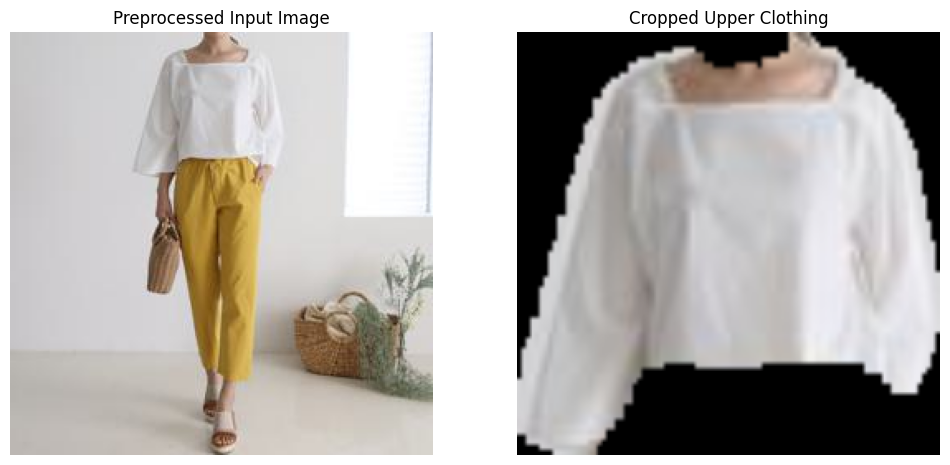

1/1 [==============================] - 1s 950ms/step
style class: [0]
color class: [20]


In [ ]:
# 사용 예시
image_path = '/content/gdrive/MyDrive/Deep learning/test/test4.jpg'
upper_crop_image, preprocessed_input_image = crop_upper_clothing(image_path)

# 정규화된 이미지 준비
test_crop_image = upper_crop_image / 255.0
output_image_path = '/content/gdrive/MyDrive/Deep learning/test_crop_image/test4_crop_image.jpg'

# 이미지 저장
plt.imsave(output_image_path, test_crop_image)
# Display the input and cropped images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Preprocessed input image
axes[0].imshow(preprocessed_input_image)
axes[0].set_title('Preprocessed Input Image')
axes[0].axis('off')

# Cropped upper clothing image
axes[1].imshow(upper_crop_image)
axes[1].set_title('Cropped Upper Clothing')
axes[1].axis('off')

plt.show()

# test_crop_image를 다른 모델에 입력으로 사용할 수 있습니다.
if len(test_crop_image.shape) == 3:
    test_crop_image = np.expand_dims(test_crop_image, axis=0)

# 모델 예측 수행
style_prediction = style.predict(test_crop_image)
style_class = np.argmax(style_prediction, axis=1)

color_prediction = color.predict(test_crop_image)
color_class = np.argmax(color_prediction, axis=1)

print(f'style class: {style_class}')
print(f'color class: {color_class}')


1/1 [==============================] - 2s 2s/step


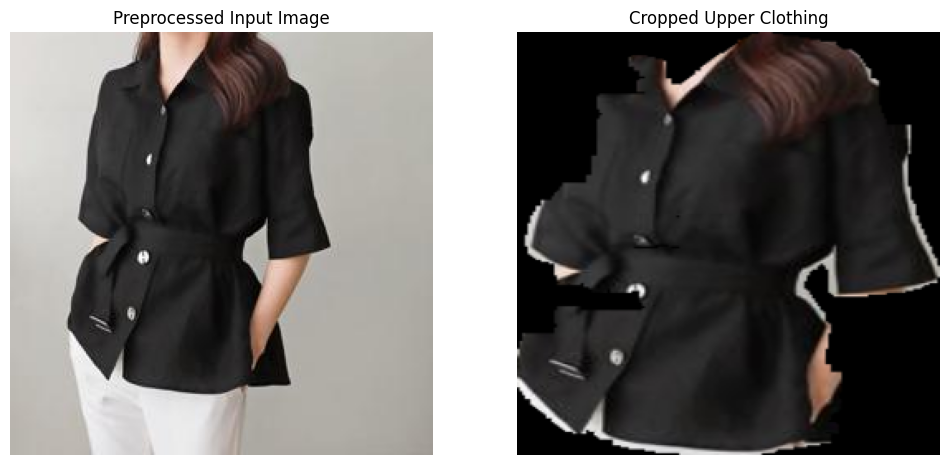

1/1 [==============================] - 1s 963ms/step
style class: [2]
color class: [10]


### 위에서 생성 된 segmentation 된 이미지를 입력으로 데이터 베이스에서 전체 착샷 출력



1. 크롭 이미지 입력
2. 모델에서 style & color 라벨 값 확인
3. style & color로 같은 값을 가지는 크롭 이미지 모으기
4. 크롭 이미지와 모인 이미지 사이 유사도 분석
5. 가장 유사도가 높은 파일의 이름으로 전체 이미지에서 찾아서 출력



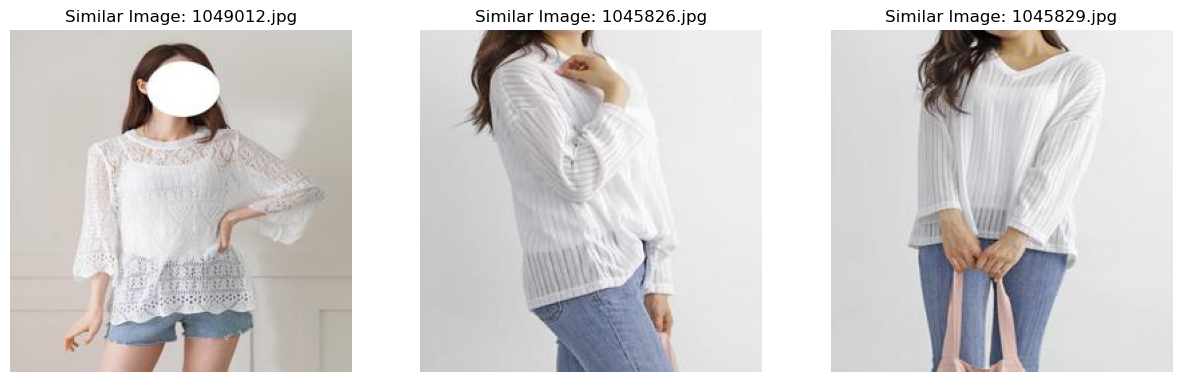

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

def calculate_histogram_similarity(hist1, hist2, method):
    # Calculate the similarity between two histograms using the specified method
    similarity = cv2.compareHist(hist1, hist2, method)
    return similarity

def get_histogram(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image at path {image_path}")
        return None
    # Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Calculate the histogram
    hist = cv2.calcHist([hsv_image], [0, 1], None, [50, 60], [0, 180, 0, 256])
    # Normalize the histogram
    hist = cv2.normalize(hist, hist, 0, 1, cv2.NORM_MINMAX)
    return hist

def find_most_similar_images(test_crop_image, folder_path, top_n=3):
    methods = {
        'Correlation': (cv2.HISTCMP_CORREL, 1),     # Higher is better
        'Chi-Square': (cv2.HISTCMP_CHISQR, -1),     # Lower is better
        'Intersection': (cv2.HISTCMP_INTERSECT, 1), # Higher is better
        'Bhattacharyya': (cv2.HISTCMP_BHATTACHARYYA, -1) # Lower is better
    }

    target_hist = get_histogram(test_crop_image)
    if target_hist is None:
        print("Error: Unable to compute histogram for the target image.")
        return []

    similarity_scores = []

    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path) and file_path != test_crop_image:
            hist = get_histogram(file_path)
            if hist is None:
                continue
            score = 0
            for method_name, (method, direction) in methods.items():
                similarity = calculate_histogram_similarity(target_hist, hist, method)
                score += direction * similarity
            similarity_scores.append((score, filename))

    # Sort the similarity scores
    similarity_scores.sort(key=lambda x: x[0], reverse=True)
    most_similar_images = [filename for _, filename in similarity_scores[:top_n]]

    return most_similar_images

def display_images(image_folder, image_filenames):
    num_images = len(image_filenames)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Create a row of subplots
    for ax, filename in zip(axes, image_filenames):
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error: Unable to read image at path {image_path}")
            continue
        # Convert BGR to RGB for displaying with matplotlib
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image_rgb)
        ax.set_title(f"Similar Image: {filename}")
        ax.axis('off')  # Hide axis
    plt.show()

# Usage
origin_image_folder = r"E:\University\5-1\deep_learning\team_project\K-Fashion\Training\database"
test_crop_image = r"E:\University\5-1\deep_learning\team_project\K-Fashion\Training\test_crop_image\test4_crop_image.jpg"
target_folder = r'E:\University\5-1\deep_learning\team_project\K-Fashion\Training\top_crop_data_100000\target_folder'

most_similar_images = find_most_similar_images(test_crop_image, target_folder, top_n=3)
if most_similar_images:
    display_images(origin_image_folder, most_similar_images)
else:
    print("No similar images found.")


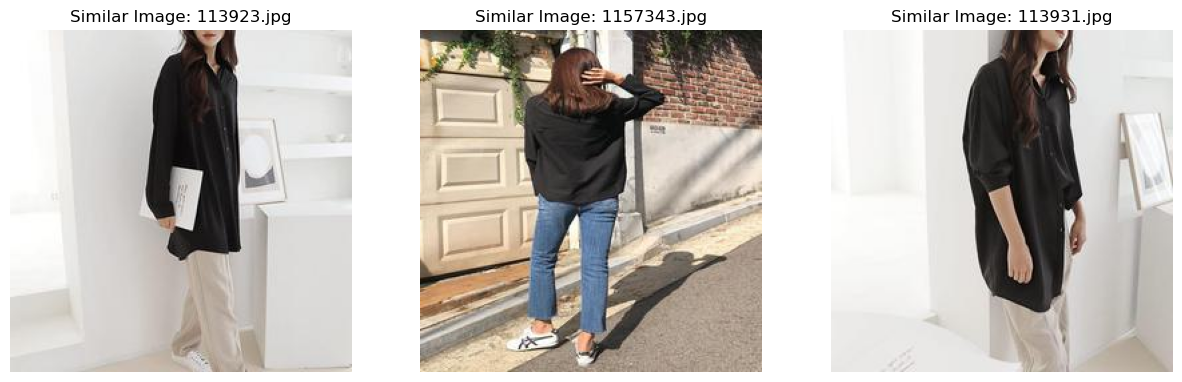

## Performance : 설문조사
<img src = "https://drive.google.com/uc?id=1FMa2llT02Dk5C_o1nK4ZVd_DN94ndlP_" height = 400 width = 500>
<img src = "https://drive.google.com/uc?id=1rFxauUPKcwj_UpU6jFIfMNfQEdKPCayM" height = 400 width = 500>  


---


<img src = "https://drive.google.com/uc?id=1I93jVGYxhVquI1x8unXYe1GgZaoLbDV6" height = 400 width = 500>
<img src = "https://drive.google.com/uc?id=1CO7ROMRN5xNg5TCAgAh1pgplFg0-Rz85" height = 400 width = 500>

## Debug


**문제**

: Rawdata 800 x 800 size로 학습 했을 때, 가진 자원의 한계로 batch_size를 1~4까지 내려야했음

1~4 batch size

 그래디언트 추정의 분산이 커지면서 최적화 과정에서 정확한 방향으로 나아가는데 방해, 성능이 좋지 않음.

**해결** :

trail 1 : 400 x 400으로 resize. 역시, memory 32G 기준 batch_size 4~8로 설정해야했음.

trial 2 :  256 x 256으로 resize, 메서드의 Image.ANTIALIAS로 고품질 다운 샘플링 .

batch_size = 32까지 가능. → 학습속도와 수렴 속도가 크게 개선되었음.

**인사이트** :

가진 자원을 고려해서, 적절한 image resize 하는 것이 중요함.

## Limit

- raw data의 이미지 사이즈는 각각 다른데, resize 과정에서의 비율을 못맞춰 줬다.

ex) 800x800 → 256 x256 으로 wrap했을때와, 800 x532 → 256 x 256으로 wrap 했을때의 비율차이 존재. → 데이터의 설명력을 높이지 못했다.
